## Qihan Guan, Michael Harris, Luyao Wang

# 1. Import Packages, data, and view summary statistics.

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import Packages. 

import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor



In [2]:
# Import test and training datasets.
train = pd.read_csv("train.csv", encoding='latin-1') #the given training dataset from Kaggle
test = pd.read_csv("test.csv", encoding='latin-1') #the true testing dataset using for submission score

In [3]:
# Use head to return first five rows and ensure that importing was done correctly. 
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Use head to return first five rows and ensure that importing was done correctly. 
test.head() #Note that the test dataset is used for submission score. The column SalePrice is excluded. 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Get info on our training dataset.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train.shape #1460 rows, 81 columns

(1460, 81)

In [7]:
# Before making transformations, let's make copies of our dataframe to which we can make changes.
train2 = train.copy()
test2 = test.copy()

# 2. Data Preprocessing and EDA

### NA Values

In [321]:
# Check for NaN's in training and testing dataset.
missing_values = pd.concat([train.isnull().sum(), test.isnull().sum()], axis = 1, keys = ['TRAIN', 'TEST'])
missing_values[missing_values.sum(axis=1)>0]

,TRAIN,TEST
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1369,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,8,16.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


Note that each feature has 1460 entries. We observe that 'Alley', 'PoolQC', and 'MiscFeature' are missing >90% of cases in both datasets. We can proceed by dropping these columns.
We can also drop the ID column, which doesn't provide any value other than identifying a unique row.

In [322]:
merged_data = train2.append(test2)

In [323]:
merged_data = merged_data.drop(['PoolQC','MiscFeature','Alley', 'Id'], axis=1)

Next, for ordinal columns and numeric columns, we repalce NA with 0.

In [324]:
for col in ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
           'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','FireplaceQu', 
            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea',
            'GarageQual','GarageCond', 'Fence']:
    merged_data[col] = merged_data[col].fillna(0)
else:
    merged_data[col] = merged_data[col].fillna('None')

Next, for ordinal columns that are not stored in a numeric format, such as ExterCond and BsmtQual, we use OrdinalEncoder to encode them instead of just dummies. 

In [325]:
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
           'GarageQual', 'GarageCond', 'Fence']

encoder = ce.OrdinalEncoder(cols=ordinal_cols)
merged_data = encoder.fit_transform(merged_data)

C:\Users\dvcgu\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [326]:
merged_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,1,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,1,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,1,0,12,2008,WD,Normal,250000.0


### Multicollinearity

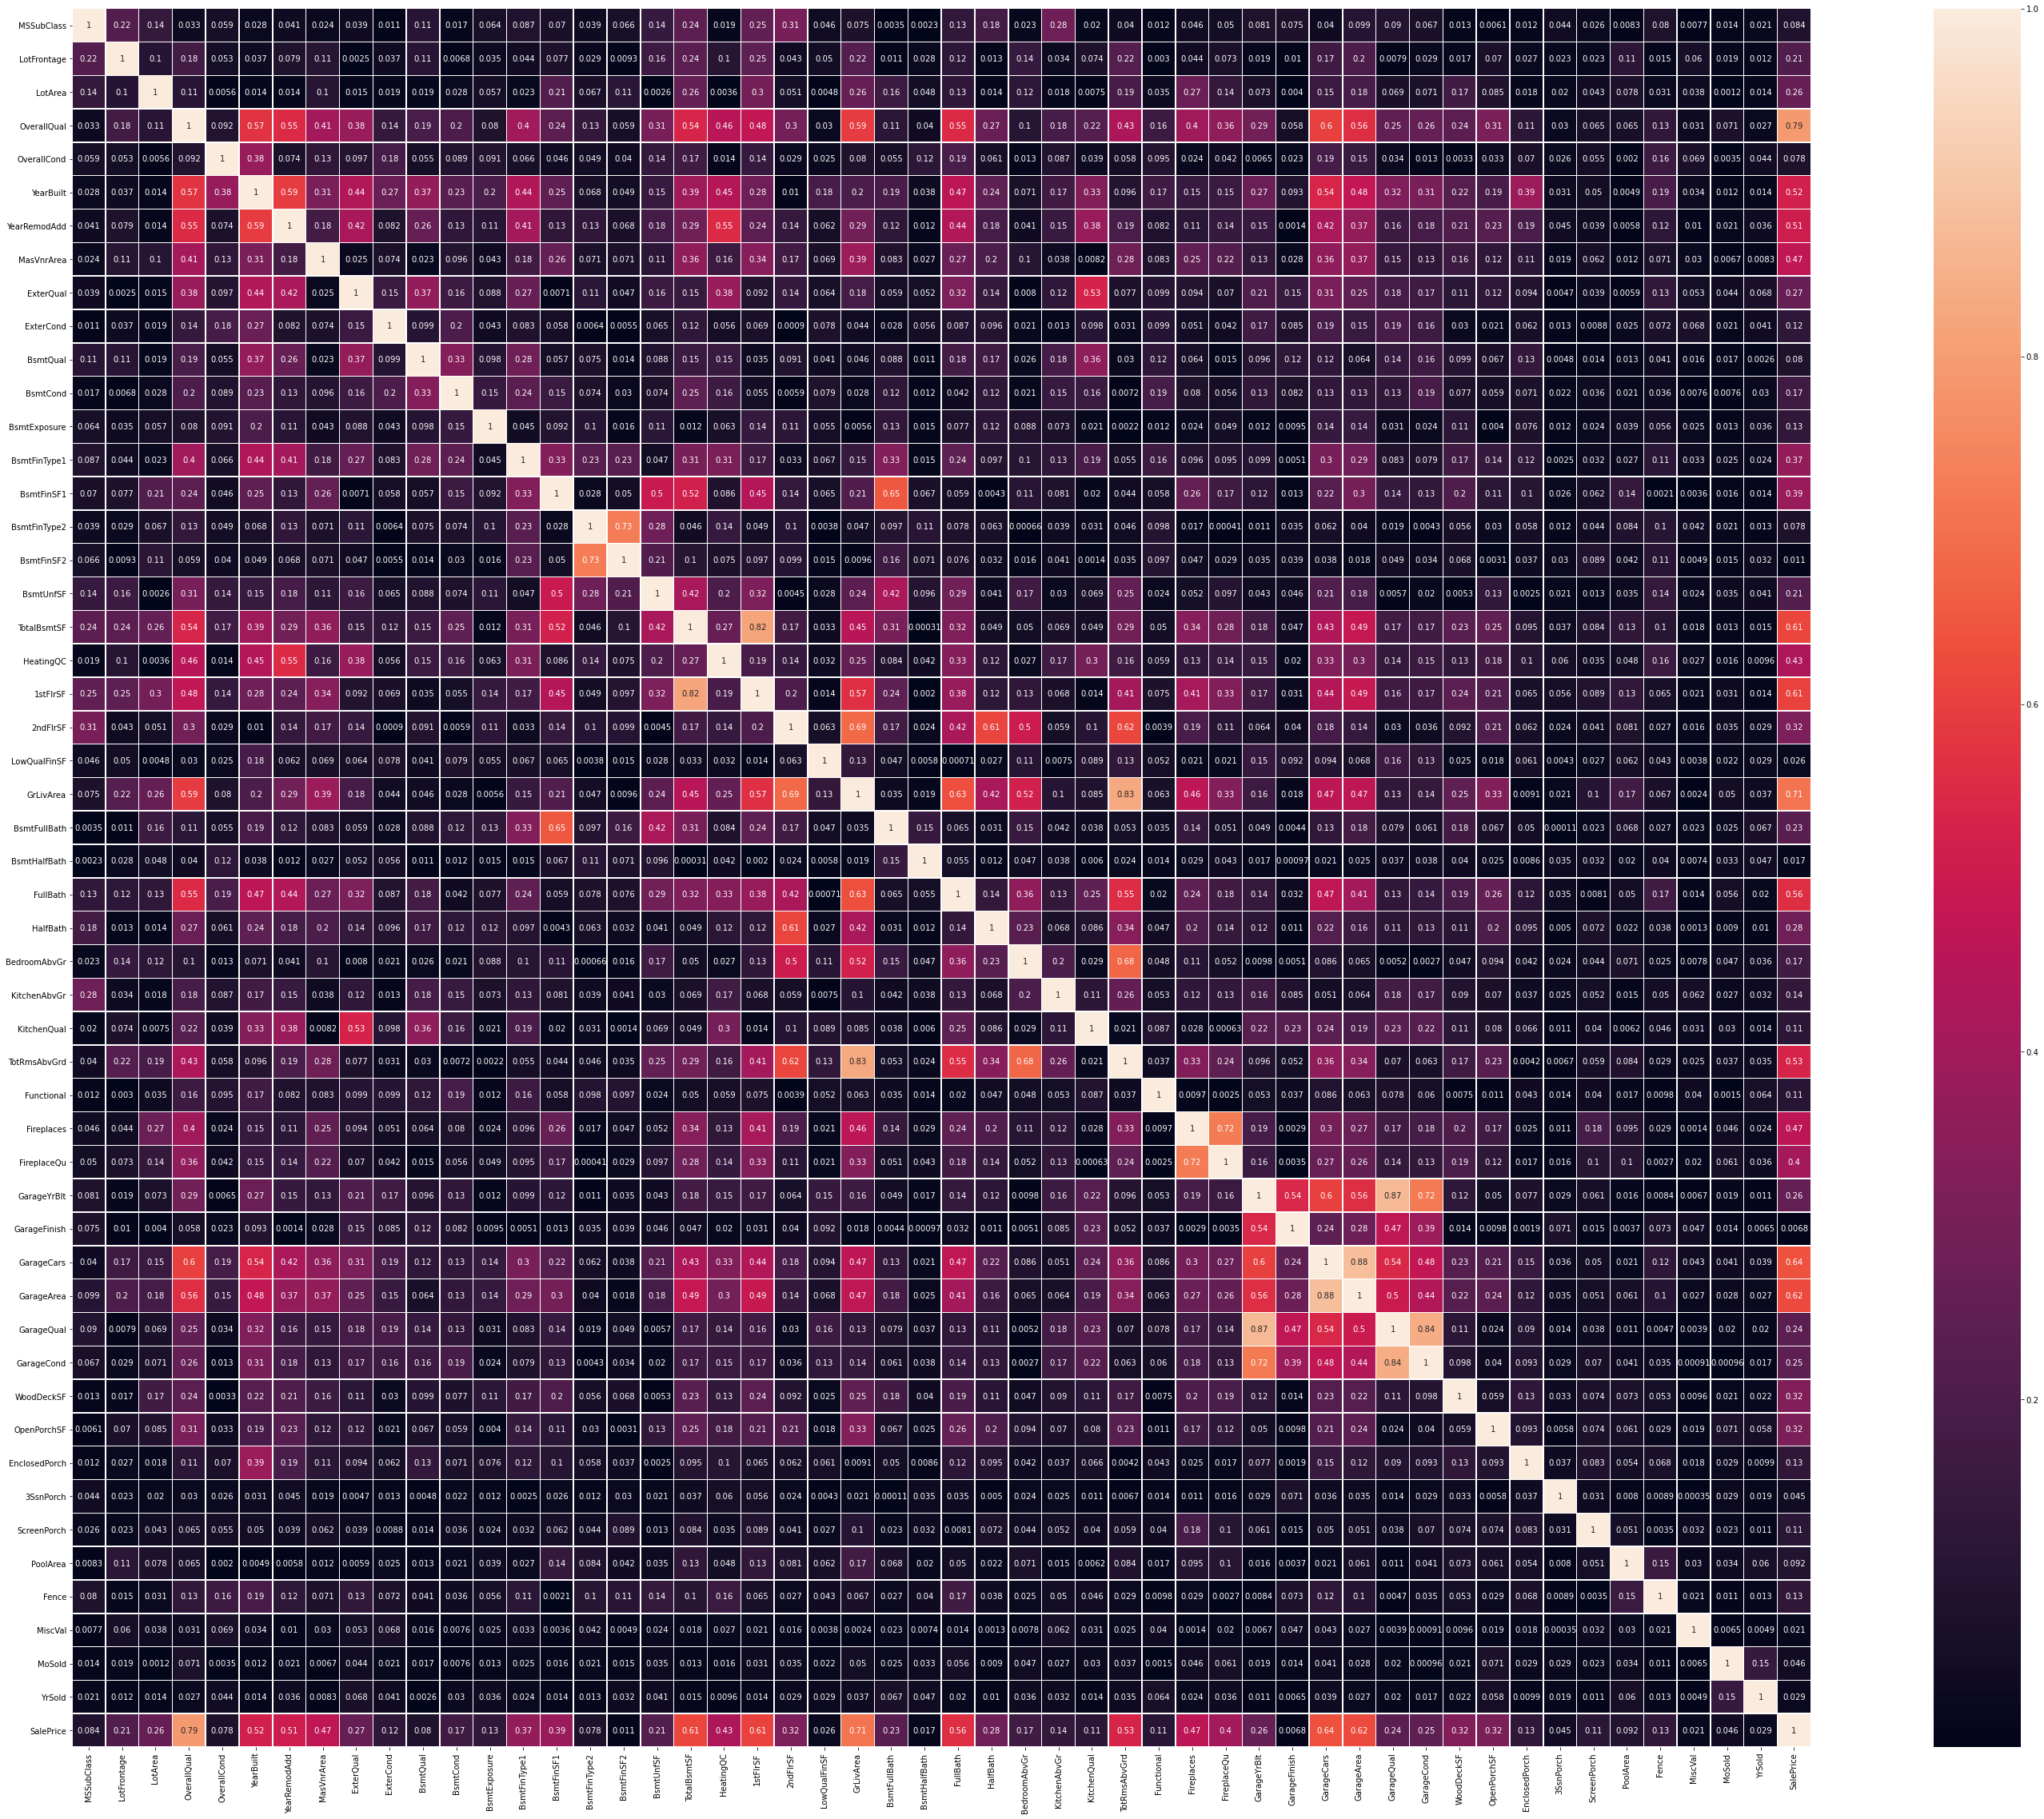

In [327]:
# Next, we can create a correlation chart for our quantitative variables and determine if any variables are highly correlated.
train2 = merged_data.iloc[:len(train2)]
train2_quant = train2.select_dtypes(exclude=['object'])

plt.subplots(figsize=(55, 40))
sns.heatmap(train2_quant.corr('pearson').abs(), annot = True, square = True, linewidths = 0.5)
plt.show()

In [328]:
# Determine strong pairs:
cor_pairs = train2_quant.corr().unstack()
strong_pairs = cor_pairs[((cor_pairs) > 0.8) & ((cor_pairs) < 1.0)]
strong_pairs

# Here are variables that are contenders to be cut due to being close to perfectly correlated:

TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
GarageQual    GarageCond      0.838396
GarageCond    GarageQual      0.838396
dtype: float64

In [329]:
# For these variables, the best alternative would be to drop one of the highly correlated variables.
# Dropping 'GarageYrBlt', '1stFlrSF', 'GarageArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageCond'

merged_data = merged_data.drop(['GarageYrBlt', '1stFlrSF', 'GarageArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageCond'], axis=1)

In [330]:
# Let's also take a look at what variables are most correlated with our dependent variable 'SalesPrice'. 

sales_cor = train2.corr('pearson').abs()['SalePrice']

# Sort by strongest correlations. 
sorted_cor_target = sales_cor.sort_values(kind = 'Quicksort', ascending=False)
sorted_cor_target

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
HeatingQC        0.427649
FireplaceQu      0.402854
BsmtFinSF1       0.386420
BsmtFinType1     0.370971
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
ExterQual        0.265015
LotArea          0.263843
GarageYrBlt      0.261366
GarageCond       0.245013
GarageQual       0.235455
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
BsmtCond         0.166927
KitchenAbvGr     0.135907
BsmtExposure     0.132027
Fence            0.128700
EnclosedPorch    0.128578
ExterCond        0.121706
KitchenQual      0.114746
ScreenPorch      0.111447
Functional  

### EDA & Transformations

We have done some preprocessing of the data. Now we can check if any transformation is necessary.

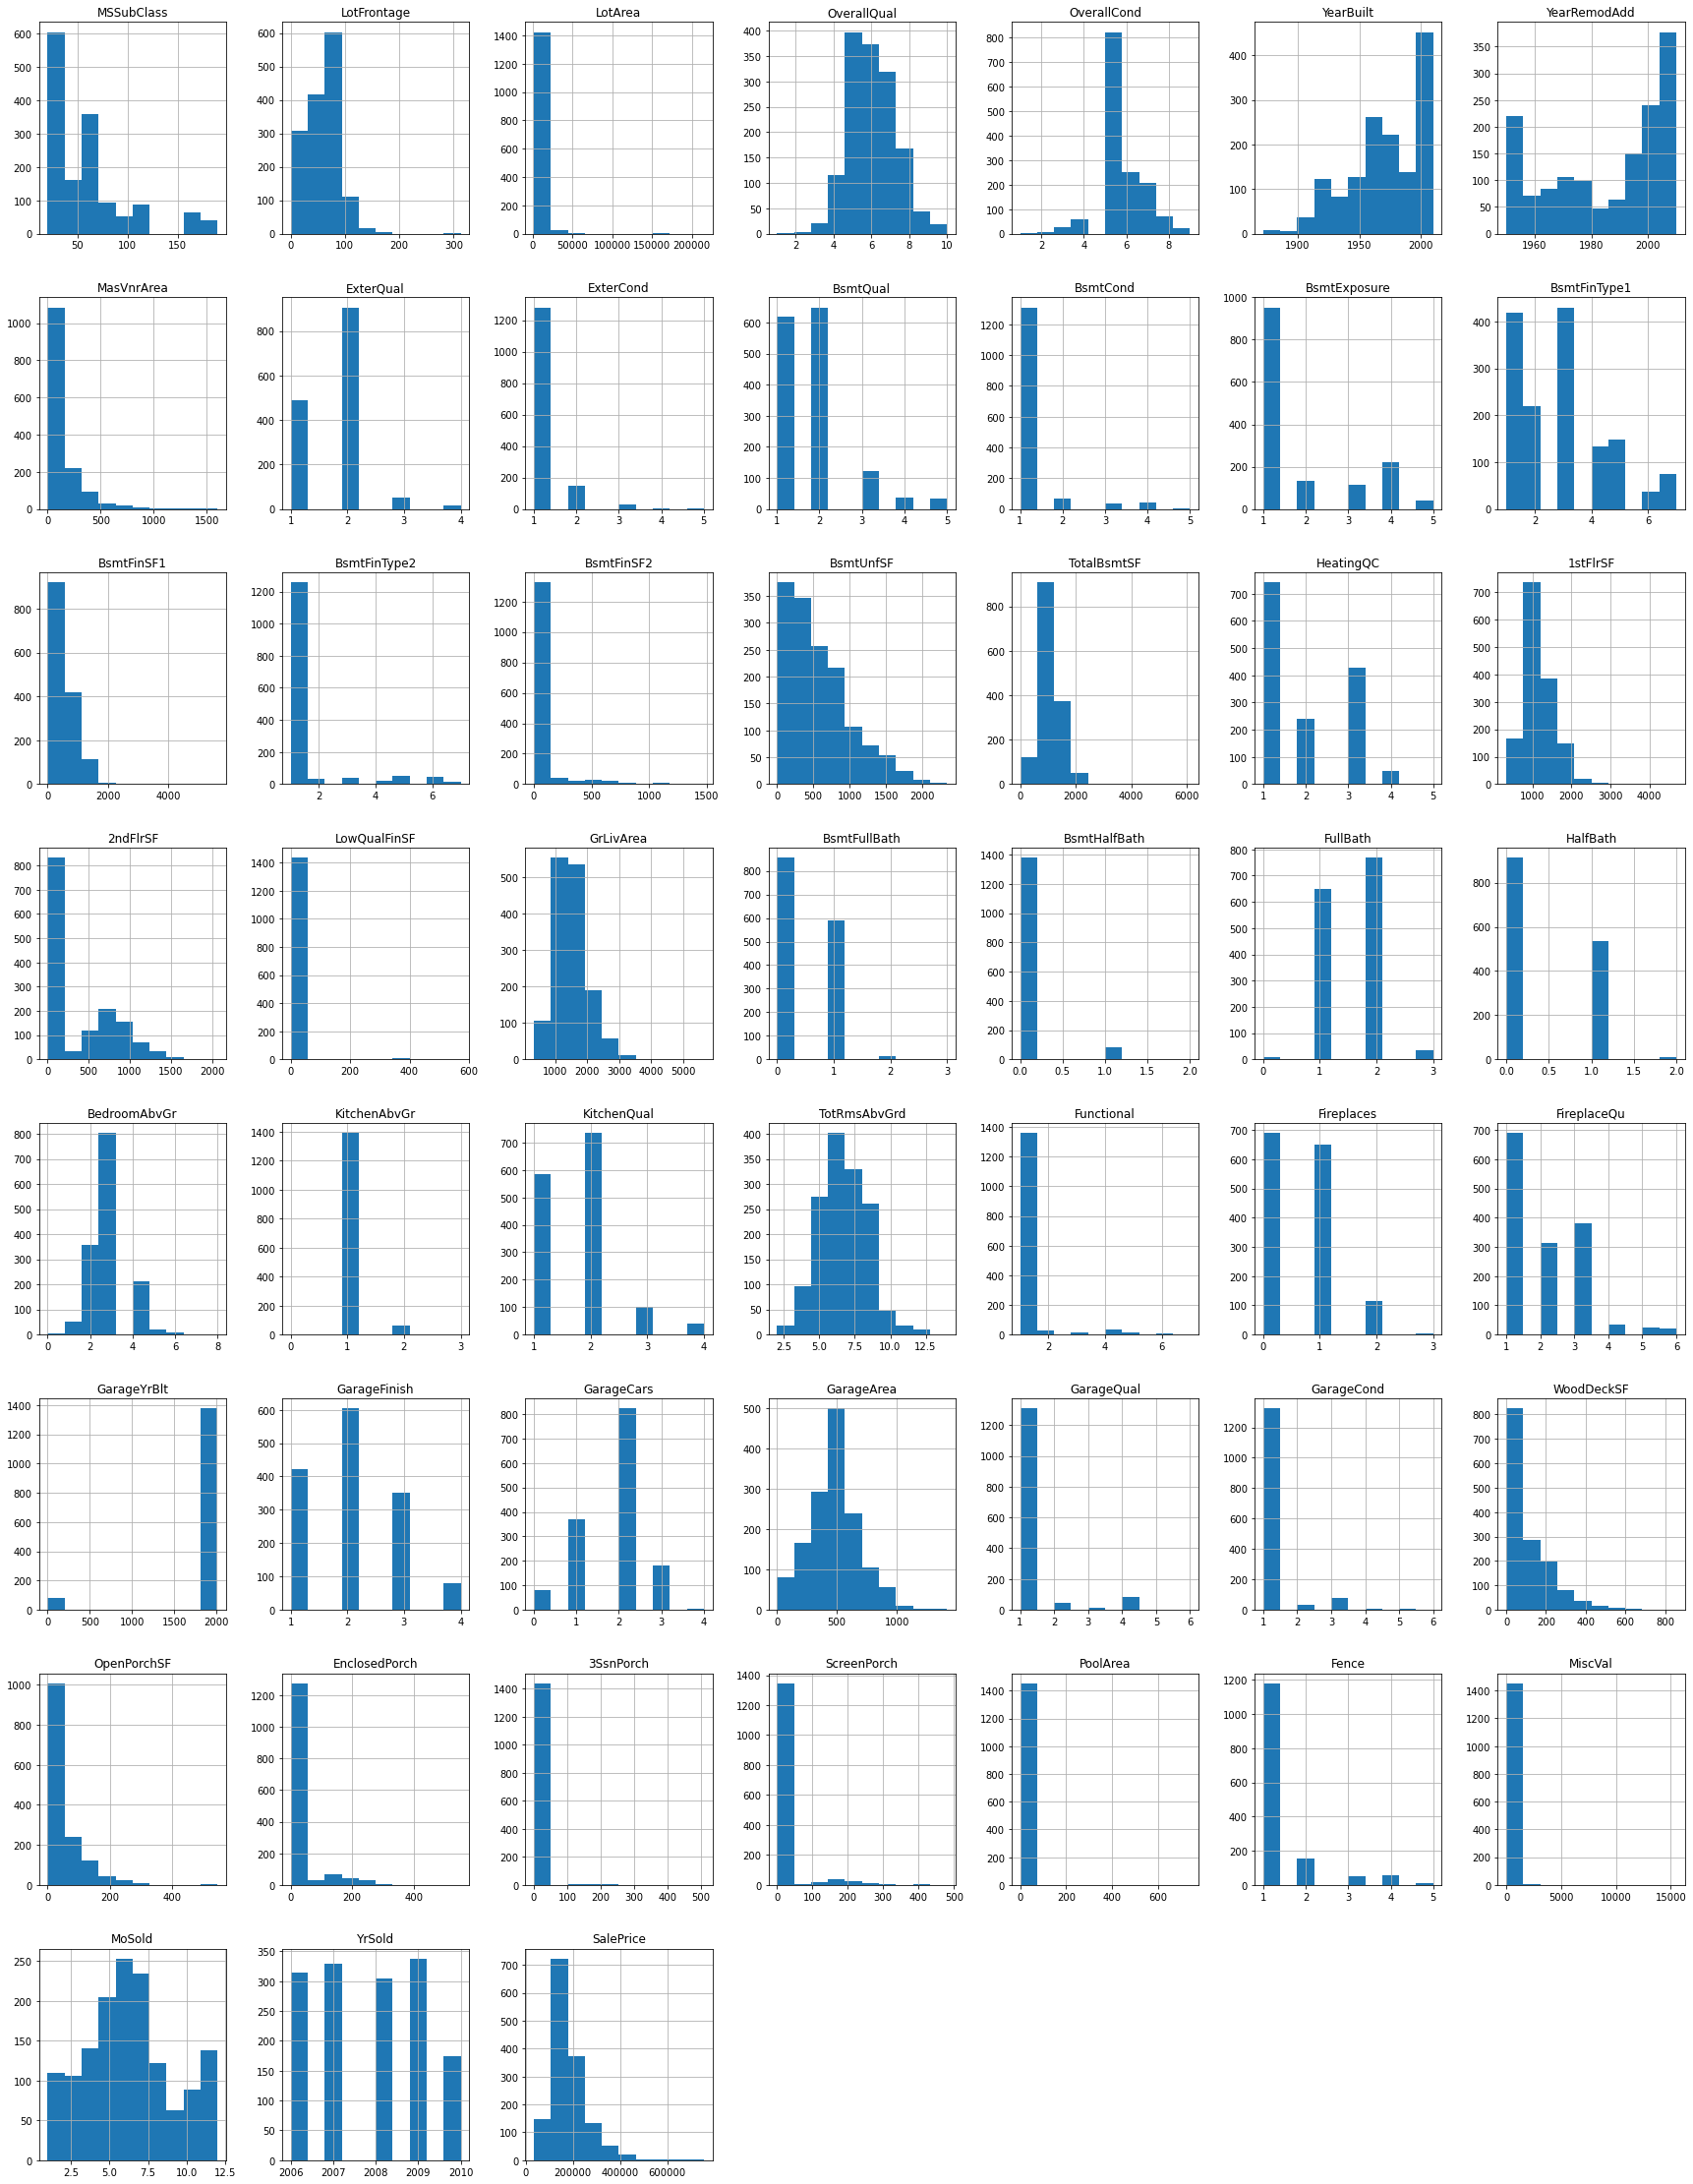

In [331]:
train2_quant = train2.select_dtypes(exclude=['object'])

quant_eda = train2.hist(column = train2_quant.columns, figsize = (30,40))

Candidates for transformation are 2ndFlrSF, BsmtFinSF1, BsmtFinSF2, ScreenPorch, PoolArea, MiscVal, LowQualFinSF, OpenPorchSF, LotArea, SalePrice. 

Our dependent variable ('SalePrice') may also be worth examining further.

We could use a logarithmic transformation to even out the distributions to more normal & smooth outliers.

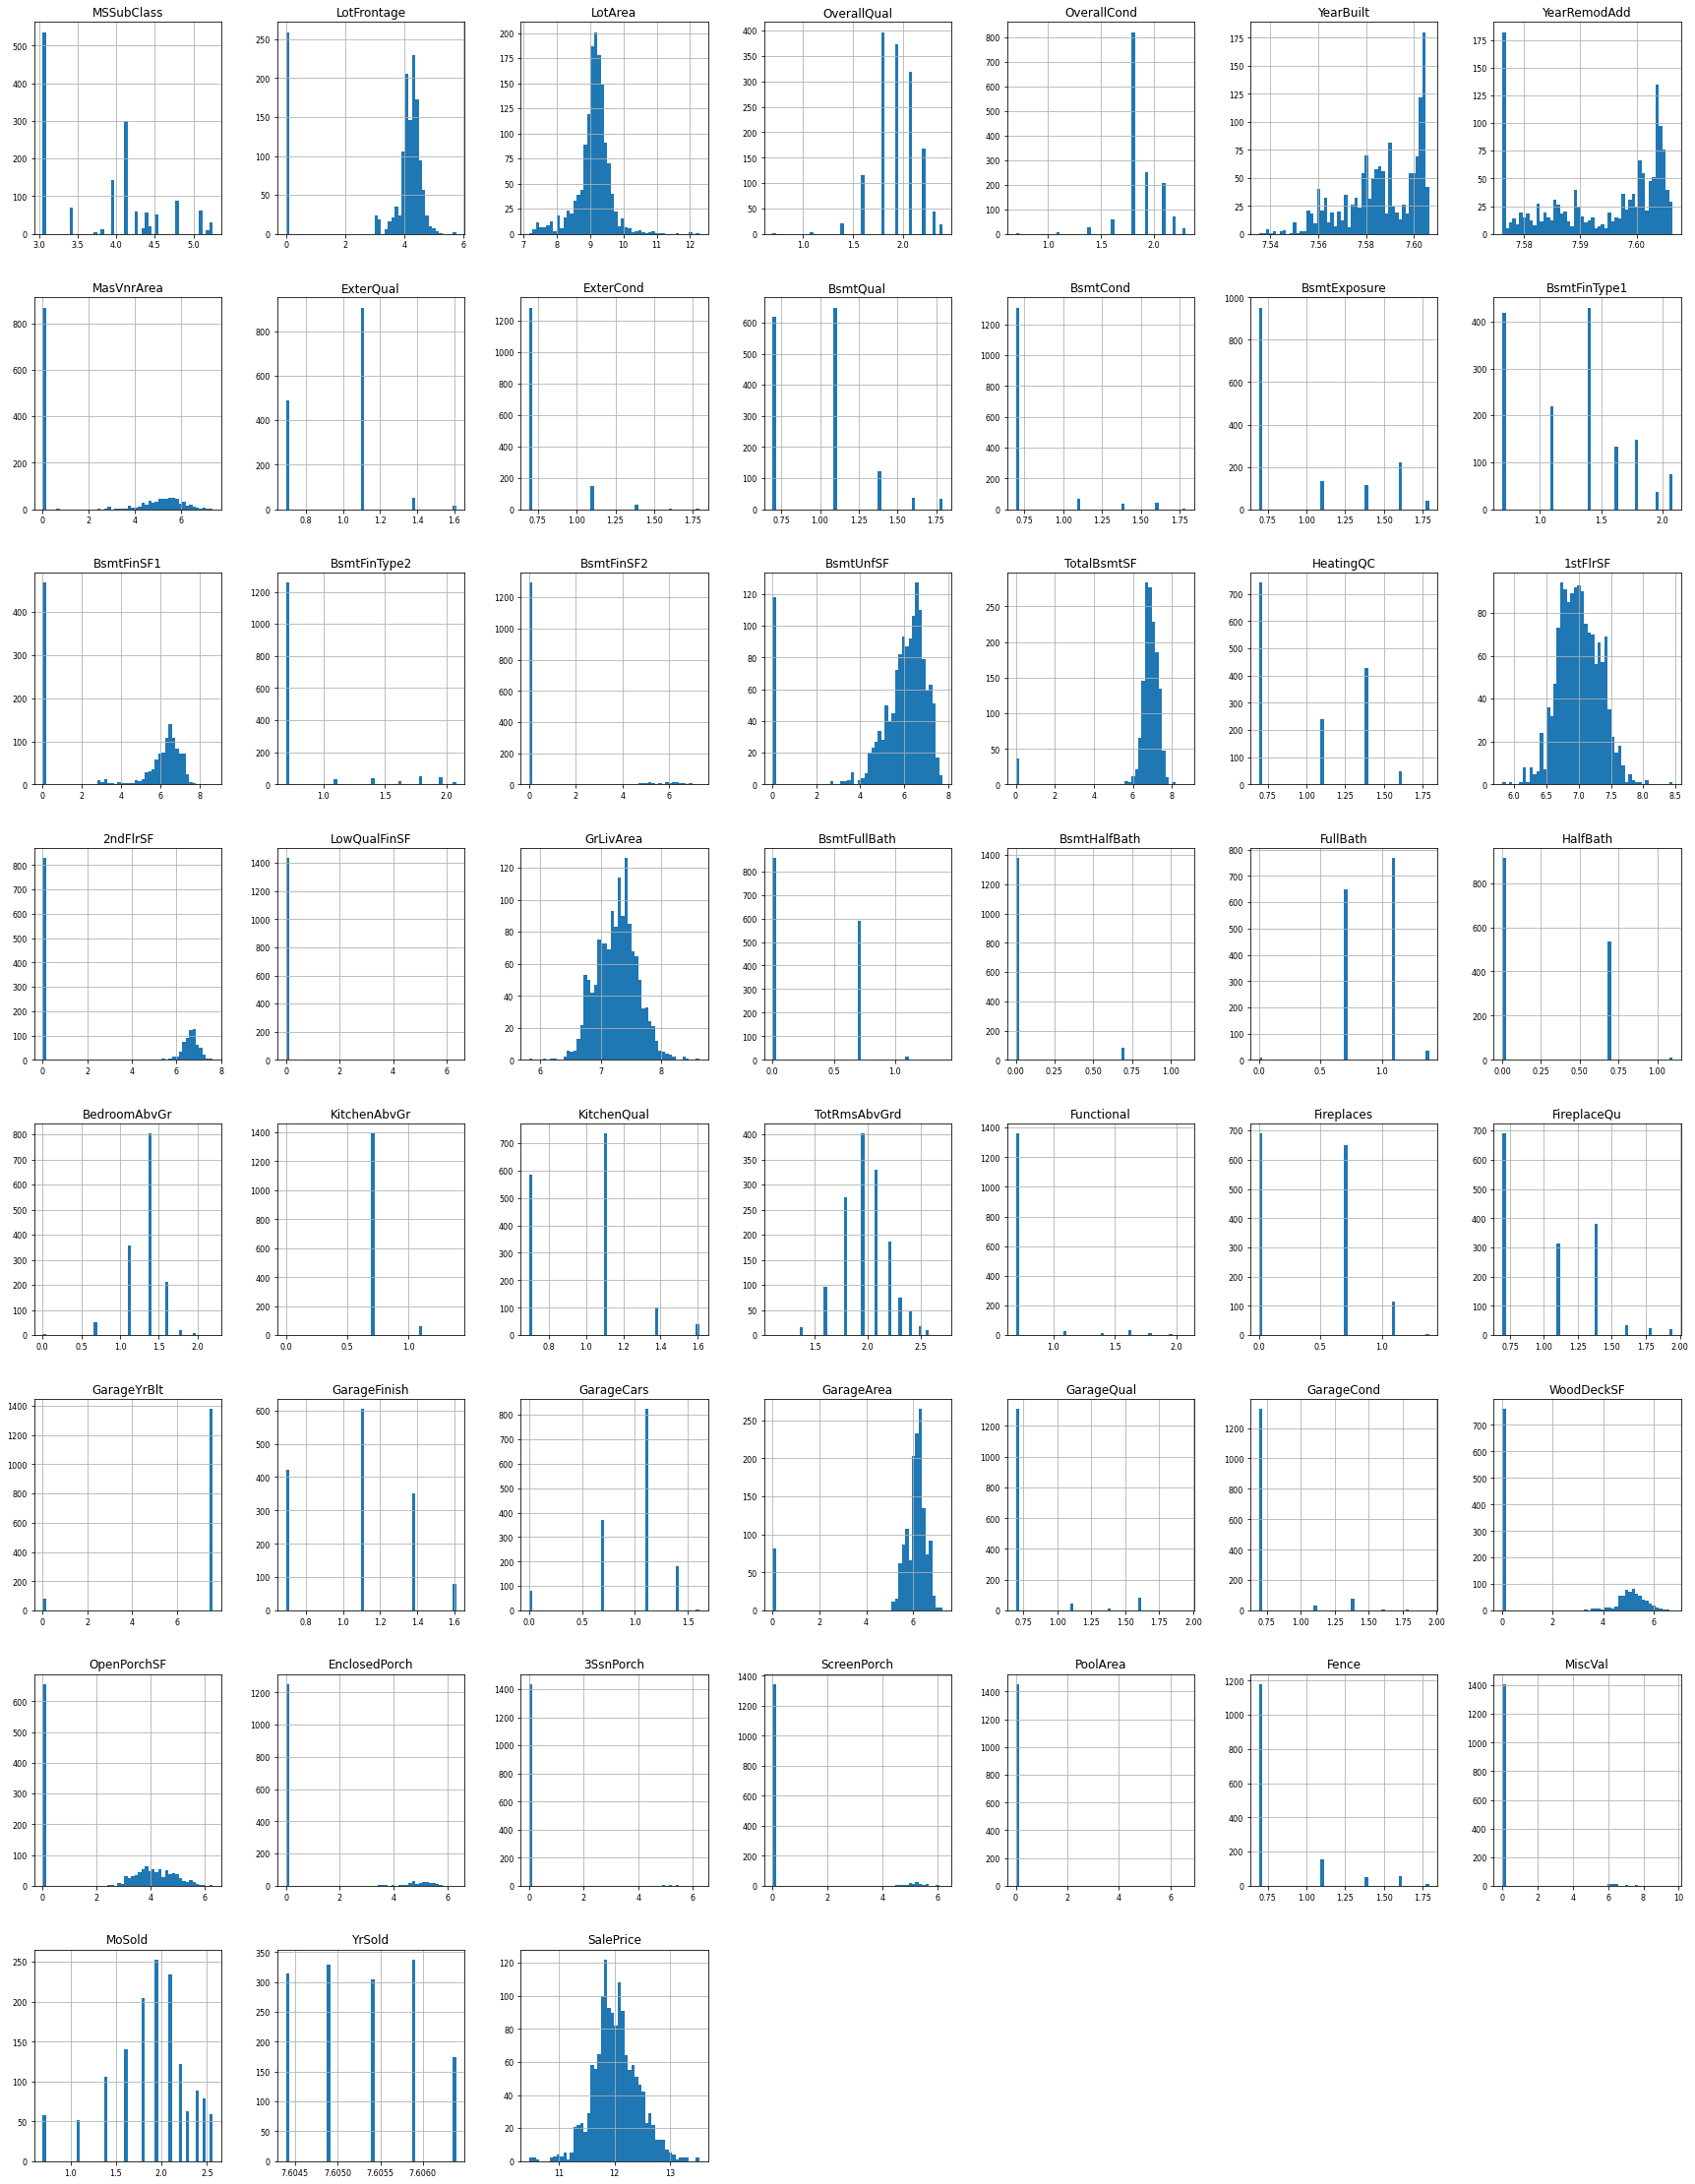

In [332]:
# Applying log transformations to all of the variables and compare the distribution

train_quant_log = train2_quant.copy()

for col in train_quant_log.columns:
    train_quant_log[col]=np.log1p(train_quant_log[col])
    
train_quant_log.hist(figsize=(30, 40), bins=50, xlabelsize=8, ylabelsize=8);

In [333]:
# From the above plots, we conclude that logging is effective at smoothing skewness for SalePrice, LotArea, BsmtUnfSF
# & GrLivArea.

merged_data['SalePrice'] = np.log1p(merged_data['SalePrice'])
merged_data['LotArea'] = np.log1p(merged_data['LotArea'])
merged_data['BsmtUnfSF'] = np.log1p(merged_data['BsmtUnfSF'])
merged_data['GrLivArea'] = np.log1p(merged_data['GrLivArea'])

### Categorical Variables: Transforming to Dummy Variables 

In [334]:
# In previous steps, we have transformed ordinal data by OrdinalEncoding
# For the rest categorical features, we create one-hot encode them
object_cols = merged_data.select_dtypes(include=['object']).columns
dummy_cols = []
for col in object_cols:
    if col not in ordinal_cols:
        dummy_cols.append(col)
merged_data = pd.get_dummies(merged_data, columns = dummy_cols) 

Train = merged_data.iloc[:len(train2)]
Test = merged_data.iloc[len(train2):].drop("SalePrice", axis = 1)

### Examine the preprocessed dataset

In [335]:
Train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,9.042040,7,5,2003,2003,196.0,1,1,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9.169623,6,8,1976,1976,0.0,2,1,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,9.328212,7,5,2001,2002,162.0,1,1,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9.164401,7,5,1915,1970,0.0,2,1,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,9.565284,8,5,2000,2000,350.0,1,1,...,0,0,0,1,0,0,0,0,1,0


In [336]:
Test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,9.360741,5,6,1961,1961,0.0,2,1,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,9.565775,6,6,1958,1958,108.0,2,1,...,0,0,0,1,0,0,0,0,1,0
2,60,74.0,9.534668,5,5,1997,1998,0.0,2,1,...,0,0,0,1,0,0,0,0,1,0
3,60,78.0,9.208238,6,6,1998,1998,20.0,2,1,...,0,0,0,1,0,0,0,0,1,0
4,120,43.0,8.518392,8,5,1992,1992,0.0,1,1,...,0,0,0,1,0,0,0,0,1,0


# 3. Model building and feature selection

## Model 1 - Linear Regression

First, drop features with very low correlation with SalePrice (<0.020)

In [337]:
quant_features = list((Train.dtypes != 'object')[Train.dtypes != 'object'].index)
low_cor_features = set()
for i in quant_features:
    if abs(Train[i].corr(Train["SalePrice"])) < 0.02:
        low_cor_features.add(i)
low_cor_features

{'BsmtFinSF2',
 'BsmtHalfBath',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Exterior1st_Plywood',
 'Exterior2nd_BrkFace',
 'Exterior2nd_Stone',
 'Foundation_Stone',
 'Foundation_Wood',
 'HouseStyle_SLvl',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_FR2',
 'Neighborhood_Blueste',
 'RoofMatl_ClyTile',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofStyle_Mansard',
 'SaleType_ConLI',
 'Utilities_AllPub',
 'Utilities_NoSeWa'}

In [338]:
# Create data copies for model 1, and drop the low correlation features
train1 = Train.copy()
test1 = Test.copy()
train1 = train1.drop(columns = low_cor_features)
test1 = test1.drop(columns = low_cor_features)

Do a train/validation split for the training data

In [339]:
X_train = train1.drop("SalePrice", axis = 1)
Y_train = train1["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

For this feature selection method, we retained 193 features.

In [340]:
len(x_train.columns)

193

Fit linear regression 

In [341]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

linear_pred = linreg.predict(x_valid)

r2 = linreg.score(x_valid, y_valid)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % (1 - (1-r2)*(len(y_valid)-1)/(len(y_valid)-x_valid.shape[1]-1)))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid,linear_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid,linear_pred)))

coefficient of determination: 0.90
adjusted R-square: 0.71
Mean Squared Error: 0.018500634026294805
Root Mean Squared Error: 0.13601703579439894


Plot predicted value vs. actual value

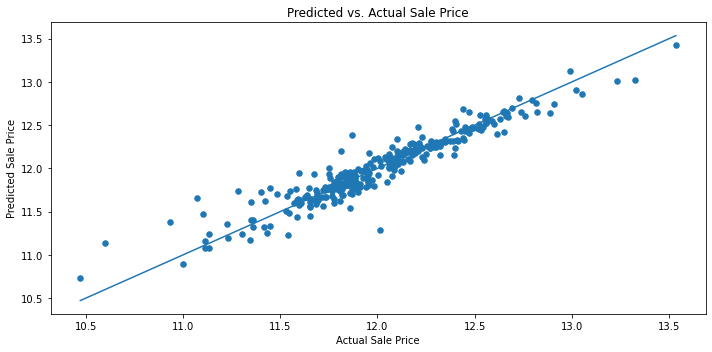

In [342]:
plt.figure(figsize=(10, 5))
plt.scatter(y_valid, linear_pred, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.tight_layout()

Feature selection using Recursive Feature Elimination

In [343]:
# Let's compare this feature selection method to recursive feature elimination in linear regression to determine the most 
# effective method of feature selection.

linreg = LinearRegression()
rfecv = RFECV(estimator=linreg)
rfecv.fit(x_train, y_train)

rce_pred = rfecv.predict(x_valid)

print('Best number of features selected: %d' % rfecv.n_features_)

r2 = rfecv.score(x_valid, y_valid)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % (1 - (1-r2)*(len(y_valid)-1)/(len(y_valid)-x_valid.shape[1]-1)))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid,rce_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid,rce_pred)))

Best number of features selected: 174
coefficient of determination: 0.90
adjusted R-square: 0.70
Mean Squared Error: 0.0188811900035664
Root Mean Squared Error: 0.13740884252320298


Plot predicted value vs. actual value

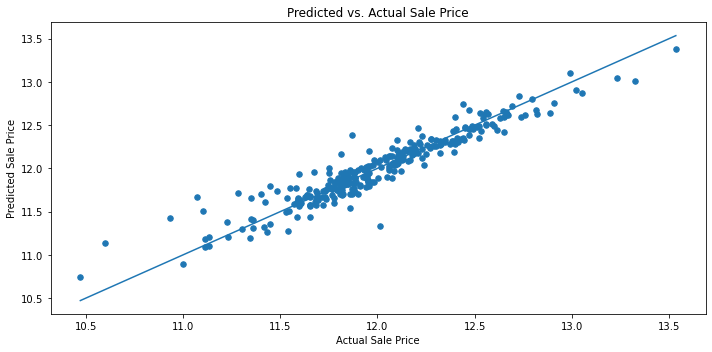

In [344]:
plt.figure(figsize=(10, 5))
plt.scatter(y_valid, rce_pred, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.tight_layout()

For this method, we retained 174 features. The performance was roughly the same as the previous method. 
But a simpler model is always better. We will use this model as the final linear regression model. 

Create Submission File for Model 1 - Linear Regression

In [345]:
y_pred = rfecv.predict(test1)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model1.csv', index=False)

## Model 2 - Elastic Net

In [457]:
train2 = Train.copy()
test2 = Test.copy()

First add degrees 2 or 3 to some suitable features

In [458]:
train2['BsmtFullBath^2'] = np.power(train2['BsmtFullBath'],2)
train2['BsmtFullBath^3'] = np.power(train2['BsmtFullBath'],3)
train2['FullBath^2'] = np.power(train2['FullBath'],2)
train2['FullBath^3'] = np.power(train2['FullBath'],3)
train2['HalfBath^2'] = np.power(train2['HalfBath'],2)
train2['HalfBath^3'] = np.power(train2['HalfBath'],3)

test2['BsmtFullBath^2'] = np.power(test2['BsmtFullBath'],2)
test2['BsmtFullBath^3'] = np.power(test2['BsmtFullBath'],3)
test2['FullBath^2'] = np.power(test2['FullBath'],2)
test2['FullBath^3'] = np.power(test2['FullBath'],3)
test2['HalfBath^2'] = np.power(test2['HalfBath'],2)
test2['HalfBath^3'] = np.power(test2['HalfBath'],3)

Train/Validation split for model2.

In [459]:
X_train = train2.drop("SalePrice", axis = 1)
Y_train = train2["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

Fit Elastic Net

In [460]:
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]}

elnet = GridSearchCV(ElasticNet(), parameters, cv = 5, n_jobs=-1, verbose=1)

elnet.fit(x_train, y_train)

print('Best Model Parameters:', elnet.best_estimator_)
print('R2 score:', elnet.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


Best Model Parameters: ElasticNet(alpha=0.001)
R2 score: 0.8728258344035822


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


OOS Performance

In [461]:
en_best = elnet.best_estimator_
en_pred_y = en_best.predict(x_valid)
print('R2 score:', en_best.score(x_valid, y_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, en_pred_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, en_pred_y)))

R2 score: 0.9065053739620548
Mean Squared Error: 0.017447124592702732
Root Mean Squared Error: 0.13208756411071684


Plot predicted value vs. actual value

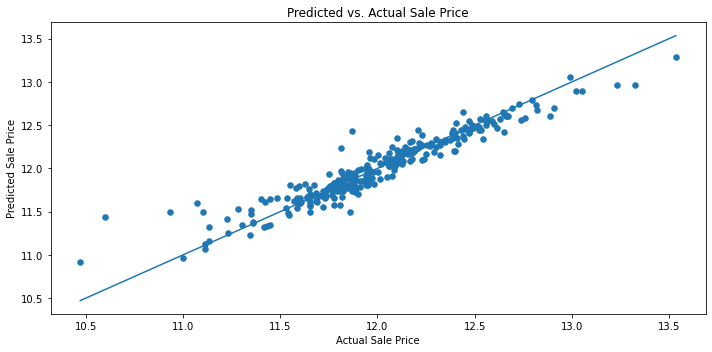

In [401]:
plt.figure(figsize=(10, 5))
plt.scatter(y_valid, en_pred_y, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.tight_layout()

Since elastic net performs automatic feature selection, we can see how many features are retained and what the most important features are.

In [463]:
en_coef = pd.Series(en_best.coef_, index = x_train.columns)

In [468]:
print("Elastic Net selected " + str(sum(en_coef != 0)) + ' features')

print("Elastic Net eliminated " + str(sum(en_coef == 0)) + ' features')

Elastic Net selected 100 features
Elastic Net eliminated 123 features


Display the significant features:

<AxesSubplot:title={'center':'Significant Variables via Elastic Net Selection'}, xlabel='coefficient'>

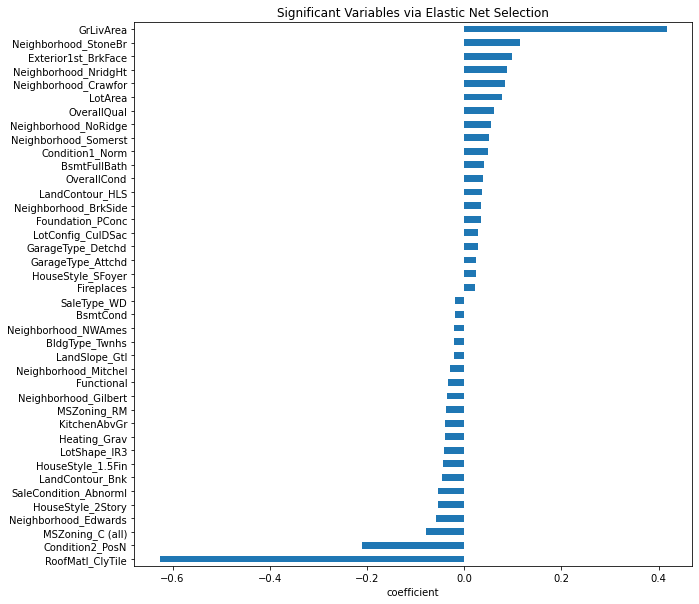

In [472]:
sig_coef = pd.concat([en_coef.sort_values().head(20), en_coef.sort_values().tail(20)])
plt.figure(figsize=(10, 10))
plt.title('Significant Variables via Elastic Net Selection')
plt.xlabel('coefficient')
sig_coef.plot(kind = 'barh')

Create Submission file for Model 2 - Elastic Net

In [402]:
y_pred = en_best.predict(test2)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model2.csv', index=False)

## Model 3 - Ridge

In [417]:
train3 = Train.copy()
test3 = Test.copy()

First add degrees 2 or 3 to some suitable features

In [418]:
train3['BsmtFullBath^2'] = np.power(train3['BsmtFullBath'],2)
train3['BsmtFullBath^3'] = np.power(train3['BsmtFullBath'],3)
train3['FullBath^2'] = np.power(train3['FullBath'],2)
train3['FullBath^3'] = np.power(train3['FullBath'],3)
train3['HalfBath^2'] = np.power(train3['HalfBath'],2)
train3['HalfBath^3'] = np.power(train3['HalfBath'],3)

test3['BsmtFullBath^2'] = np.power(test3['BsmtFullBath'],2)
test3['BsmtFullBath^3'] = np.power(test3['BsmtFullBath'],3)
test3['FullBath^2'] = np.power(test3['FullBath'],2)
test3['FullBath^3'] = np.power(test3['FullBath'],3)
test3['HalfBath^2'] = np.power(test3['HalfBath'],2)
test3['HalfBath^3'] = np.power(test3['HalfBath'],3)

Train/Validation split for model 3.

In [419]:
X_train = train3.drop("SalePrice", axis = 1)
Y_train = train3["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

Fit Ridge

In [420]:
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]}

ridge = GridSearchCV(Ridge(), parameters, cv = 10, n_jobs=-1, verbose=1)

ridge.fit(x_train, y_train)

print('Best Model Parameters:', ridge.best_params_)
print('R2 score:', ridge.best_score_)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


Best Model Parameters: {'alpha': 1.0}
R2 score: 0.8661974366546967


OOS Performance

In [421]:
ridge_best = ridge.best_estimator_
ridge_pred_y = ridge_best.predict(x_valid)
print('R2 score:', ridge_best.score(x_valid, y_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, ridge_pred_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, ridge_pred_y)))

R2 score: 0.9123074367595788
Mean Squared Error: 0.016364395918201127
Root Mean Squared Error: 0.12792339863449972


Plot predicted value vs. actual value

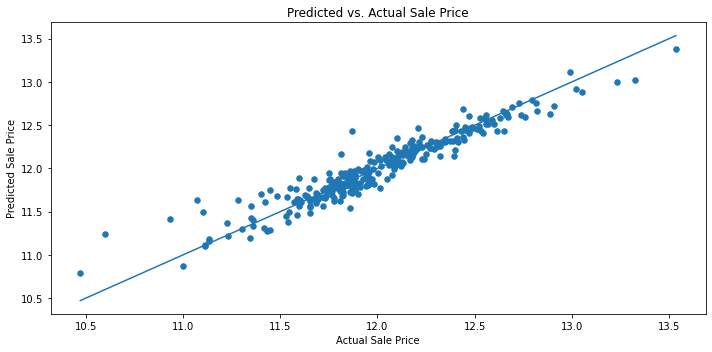

In [422]:
plt.figure(figsize=(10, 5))
plt.scatter(y_valid, ridge_pred_y, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.tight_layout()

Create Submission file for Model 3 - Ridge

In [426]:
y_pred = ridge_best.predict(test3)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model3.csv', index=False)

## Model 4 - Decision Tree

Do a train/validation split for the training data

In [428]:
# Train/Validation split
train4 = Train.copy()
test4 = Test.copy()
X_train = train4.drop("SalePrice", axis = 1)
Y_train = train4["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

Fit decision tree regresser

In [277]:
#Decision Tree Regressor; we'll run through Cross-Validation with 5 Folds, and will vary 
#the parameters using GridSearchCV to evaluate the best model. 

parameters = {
    'min_samples_split' : range(1,20),
    'min_samples_leaf' : range(1,20),
    'max_depth' : range(1,32)
}

Decision_Tree = GridSearchCV(DecisionTreeRegressor(), parameters, cv = 5, n_jobs=-1, verbose=1)

Decision_Tree.fit(x_train, y_train)

print('Best Model Parameters:', Decision_Tree.best_estimator_)
print('R2 score:', Decision_Tree.best_score_)


Fitting 5 folds for each of 11191 candidates, totalling 55955 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 10200 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 17400 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 26200 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 36600 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 48600 tasks      | elapsed:   55.0s


Best Model Parameters: DecisionTreeRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=4)
R2 score: 0.7857286634058941


[Parallel(n_jobs=-1)]: Done 55955 out of 55955 | elapsed:  1.1min finished


OOS performance:

In [284]:
dt_best = Decision_Tree.best_estimator_
dt_pred_y = dt_best.predict(x_valid)
print('R2 score:', dt_best.score(x_valid, y_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, dt_pred_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, dt_pred_y)))

R2 score: 0.8049074393038316
Mean Squared Error: 0.03640641561787756
Root Mean Squared Error: 0.19080465302994462


Plot predicted value vs. actual value

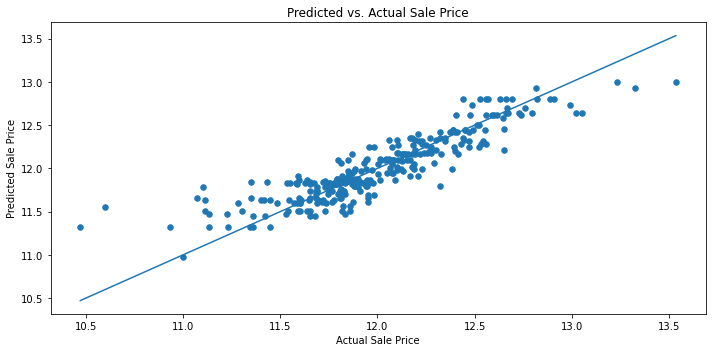

In [280]:
# Prediction Graph for our best Decision Tree. 
plt.figure(figsize=(10, 5))
plt.scatter(y_valid, dt_pred_y, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.tight_layout()

Create Submission File for Model 4 - Decision Tree

In [429]:
y_pred = dt_best.predict(test4)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model4.csv', index=False)

## Model 5 - Random Forest 

In [433]:
# Train/Validation split
train5 = Train.copy()
test5 = Test.copy()
X_train = train5.drop("SalePrice", axis = 1)
Y_train = train5["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

Fit Random Forest

In [357]:
# Get best fitting model by evaluating different parameters.
parameters = {
    'n_estimators'      : [25, 50, 100, 200, 300, 400, 500],
    'max_depth'         : [15, 20, 25, 30, 35, 40, 45]   
}

random_forest = GridSearchCV(RandomForestRegressor(), parameters, cv = 10, n_jobs=10, verbose=1)

random_forest.fit(x_train, y_train)

print('Best Model Parameters:', random_forest.best_estimator_)
print('R2 score:', random_forest.best_score_)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   46.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 490 out of 490 | elapsed:  2.4min finished


Best Model Parameters: RandomForestRegressor(max_depth=20, n_estimators=400)
R2 score: 0.8615545878788227


OOS performance

In [360]:
rf_best = random_forest.best_estimator_
rf_pred_y = rf_best.predict(x_valid)
print('R2 score:', rf_best.score(x_valid, y_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid,rf_pred_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid,rf_pred_y)))

R2 score: 0.8825709191802081
Mean Squared Error: 0.0219135568608826
Root Mean Squared Error: 0.14803228317121436


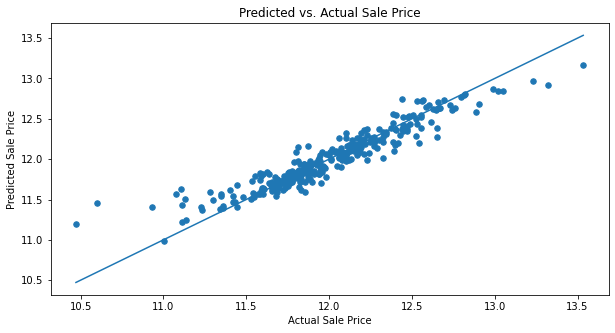

In [362]:
# Plot predicted vs. Actuals 

plt.figure(figsize=(10, 5))
plt.scatter(y_valid,rf_pred_y, s=30)
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)])
plt.show()

Create Submission File for Model 5 - Random Forest

In [434]:
y_pred = rf_best.predict(test5)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model5.csv', index=False)

## Model 6 - XGBoost

In [447]:
# Train/Validation split
train6 = Train.copy()
test6 = Test.copy()
X_train = train6.drop("SalePrice", axis = 1)
Y_train = train6["SalePrice"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

Fit XGBoost

In [453]:
# Get best fitting model by evaluating different parameters.
parameters = {
    'n_estimators'      : [3600,7200],
    'learning_rate'     : [0.01],
    'max_depth'         : [4,5],
    'min_child_weight'  : [0,1.5],
    'gamma'             : [0.0],
    'reg_alpha'         : [0.00006, 0.9],
    'subsample'         : [0.2],
    'seed'              : [42]
}

xgb = GridSearchCV(XGBRegressor(), parameters, cv = 5, n_jobs=-1, verbose=1)

xgb.fit(x_train, y_train)

print('Best Model Parameters:', xgb.best_params_)
print('R2 score:', xgb.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished


Best Model Parameters: {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 7200, 'reg_alpha': 0.9, 'seed': 42, 'subsample': 0.2}
R2 score: 0.8968454497889254


OOS Performance

In [454]:
xgb_best = xgb.best_estimator_
xgb_pred_y = xgb_best.predict(x_valid)
print('R2 score:', xgb_best.score(x_valid, y_valid))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid,xgb_pred_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid,xgb_pred_y)))

R2 score: 0.8967931787244829
Mean Squared Error: 0.019259526947355703
Root Mean Squared Error: 0.13877869774340623


Create submission file for model 6

In [455]:
y_pred = xgb_best.predict(test6)
y_pred = np.exp(1)**y_pred

y_test = pd.DataFrame(y_pred, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_test['SalePrice']], axis = 1)

test_results.to_csv('rf_output_model6.csv', index=False)

# 4. Final Submission

We will combine the predictions from the elastic net model and the XGBoost model by averaging them to get our final submission.

In [456]:
y_pred2 = en_best.predict(test2)
y_pred2 = np.exp(1)**y_pred2

y_pred6 = xgb_best.predict(test6)
y_pred6 = np.exp(1)**y_pred6

y_pred_final = (y_pred2 + y_pred6)/2

y_final = pd.DataFrame(y_pred_final, columns=['SalePrice'])

test_results = pd.concat([test['Id'],y_final['SalePrice']], axis = 1)

test_results.to_csv('output_final.csv', index=False)